# HealthSphere AI - YOLOv8 Food Detection Training

This notebook trains a YOLOv8 model for food detection using your custom dataset of 30 food categories.

## Dataset Overview
- **Total Images**: 1,596
- **Food Classes**: 30 categories
- **Format**: YOLOv8 annotations
- **Split**: Train (1,204) / Valid (313) / Test (79)

## Training Goals
- Train YOLOv8 model for real-time food detection
- Optimize for mobile deployment
- Export model for HealthSphere AI backend integration


## Step 1: Environment Setup


In [ ]:
# Check GPU availability
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")


CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: Tesla T4


In [ ]:
# Install required packages
!pip install ultralytics
!pip install roboflow
!pip install pillow
!pip install matplotlib
!pip install seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
# Import necessary libraries
import os
import shutil
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO
import torch
from IPython.display import Image, display
import zipfile
from google.colab import files, drive

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")


## Step 2: Dataset Upload and Setup

### Option A: Upload Dataset ZIP File
Zip your `Food_Dataset` folder and upload it here.


In [ ]:
# Option A: Upload dataset ZIP file
print("Please upload your Food_Dataset.zip file")
uploaded = files.upload()

# Extract the dataset
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        print(f"Extracting {filename}...")
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('.')
        print("Dataset extracted successfully!")
        break


Please upload your Food_Dataset.zip file


Saving Food_Dataset.zip to Food_Dataset (1).zip
Extracting Food_Dataset (1).zip...
Dataset extracted successfully!


## Step 3: Dataset Verification and Configuration


In [ ]:
# Verify dataset structure and prepare for training
dataset_path = '/content/Food_Dataset'

def verify_dataset_structure(dataset_path):
    """Verify the YOLOv8 dataset structure"""
    required_folders = ['train/images', 'train/labels', 'valid/images', 'valid/labels', 'test/images', 'test/labels']

    print("Dataset Structure Verification:")
    print("=" * 50)

    all_folders_exist = True
    for folder in required_folders:
        folder_path = os.path.join(dataset_path, folder)
        if os.path.exists(folder_path):
            file_count = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.txt'))])
            print(f"OK {folder}: {file_count} files")
        else:
            print(f"MISSING {folder}: NOT FOUND")
            all_folders_exist = False

    # Check data.yaml
    yaml_path = os.path.join(dataset_path, 'data.yaml')
    if os.path.exists(yaml_path):
        print(f"OK data.yaml: EXISTS")
        return all_folders_exist
    else:
        print(f"MISSING data.yaml: NOT FOUND")
        return False

# Verify dataset structure
dataset_valid = verify_dataset_structure(dataset_path)

if not dataset_valid:
    print("WARNING: Please ensure your dataset is uploaded and extracted correctly before proceeding.")
else:
    print("SUCCESS: Dataset verification completed successfully!")


Dataset Structure Verification:
OK train/images: 1204 files
OK train/labels: 1204 files
OK valid/images: 313 files
OK valid/labels: 313 files
OK test/images: 79 files
OK test/labels: 79 files
OK data.yaml: EXISTS
SUCCESS: Dataset verification completed successfully!


In [ ]:
# Load and configure dataset
yaml_path = os.path.join(dataset_path, 'data.yaml')

if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as file:
        data_config = yaml.safe_load(file)

    print("Dataset Configuration:")
    print("=" * 50)
    print(f"Number of classes: {data_config['nc']}")
    print(f"\nFood Classes ({len(data_config['names'])}):")
    for i, class_name in enumerate(data_config['names']):
        print(f"{i:2d}: {class_name}")

    # Update paths for Colab environment
    data_config['train'] = '/content/Food_Dataset/train/images'
    data_config['val'] = '/content/Food_Dataset/valid/images'
    data_config['test'] = '/content/Food_Dataset/test/images'

    # Save updated yaml for training
    colab_yaml_path = '/content/dataset.yaml'
    with open(colab_yaml_path, 'w') as file:
        yaml.dump(data_config, file)

    print(f"\nSUCCESS: Dataset configuration updated for Colab: {colab_yaml_path}")
else:
    print("ERROR: Cannot proceed without data.yaml file")


Dataset Configuration:
Number of classes: 30

Food Classes (30):
 0: baby corn
 1: bean sprout
 2: black glutinous rice
 3: boiled egg
 4: brocoli
 5: cabbage
 6: carrot
 7: chicken breast
 8: chicken leg
 9: corn
10: cucumber
11: dark green leaf vegetable
12: fried chicken
13: fried egg
14: fried tofu
15: green bean
16: green pepper
17: oily tofu
18: okra
19: pork chop
20: rice
21: salmon
22: sausage
23: scrambled eggs with tomatoes
24: shred chicken
25: shrimp
26: shrimp roll
27: stewed pork
28: sweet potato
29: tomato

SUCCESS: Dataset configuration updated for Colab: /content/dataset.yaml


## Step 4: Training Configuration


In [ ]:
# Training configuration
TRAINING_CONFIG = {
    'model_size': 'yolov8n.pt',  # Options: yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt
    'epochs': 100,               # Number of training epochs
    'batch_size': 16,            # Batch size (adjust based on GPU memory)
    'image_size': 640,           # Input image size
    'patience': 50,              # Early stopping patience
    'save_period': 10,           # Save model every N epochs
    'workers': 8,                # Number of worker threads
    'device': 0 if torch.cuda.is_available() else 'cpu',  # GPU device
    'lr0': 0.01,                # Initial learning rate
    'lrf': 0.1,                 # Final learning rate (lr0 * lrf)
    'momentum': 0.937,          # SGD momentum
    'weight_decay': 0.0005,     # Optimizer weight decay
    'warmup_epochs': 3,         # Warmup epochs
    'warmup_momentum': 0.8,     # Warmup initial momentum
    'warmup_bias_lr': 0.1,      # Warmup initial bias lr
}

print("Training Configuration:")
print("=" * 50)
for key, value in TRAINING_CONFIG.items():
    print(f"{key:15s}: {value}")

# Create results directory
results_dir = '/content/training_results'
os.makedirs(results_dir, exist_ok=True)
print(f"\nResults will be saved to: {results_dir}")


Training Configuration:
model_size     : yolov8n.pt
epochs         : 100
batch_size     : 16
image_size     : 640
patience       : 50
save_period    : 10
workers        : 8
device         : 0
lr0            : 0.01
lrf            : 0.1
momentum       : 0.937
weight_decay   : 0.0005
warmup_epochs  : 3
warmup_momentum: 0.8
warmup_bias_lr : 0.1

Results will be saved to: /content/training_results


## Step 5: Model Training


In [ ]:
# Training configuration
TRAINING_CONFIG = {
    'model_size': 'yolov8n.pt',  # Options: yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt
    'epochs': 100,               # Number of training epochs
    'batch_size': 16,            # Batch size (adjust based on GPU memory)
    'image_size': 640,           # Input image size
    'patience': 50,              # Early stopping patience
    'save_period': 10,           # Save model every N epochs
    'workers': 8,                # Number of worker threads
    'device': 0 if torch.cuda.is_available() else 'cpu',  # GPU device
}

# Start training
print("Starting model training...")
print("This may take several hours depending on your configuration.")
print("=" * 70)

results_dir = '/content/training_results'

model = YOLO(TRAINING_CONFIG['model_size'])

# Train the model
results = model.train(
    data='/content/dataset.yaml',
    epochs=TRAINING_CONFIG['epochs'],
    batch=TRAINING_CONFIG['batch_size'],
    imgsz=TRAINING_CONFIG['image_size'],
    patience=TRAINING_CONFIG['patience'],
    save_period=TRAINING_CONFIG['save_period'],
    workers=TRAINING_CONFIG['workers'],
    device=TRAINING_CONFIG['device'],
    project=results_dir,
    name='food_detection_v1',
    exist_ok=True,
    verbose=True,
    plots=True,
    save=True,
    save_txt=True
)

print("\nSUCCESS: Training completed!")
print(f"Results saved to: {results_dir}/food_detection_v1")


Starting model training...
This may take several hours depending on your configuration.
Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=food_detection_v1, nbs=64, nms=False, opset=None, optimize=False, optimizer

train: Scanning /content/Food_Dataset/train/labels... 1204 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1204/1204 [00:00<00:00, 2419.84it/s]


train: New cache created: /content/Food_Dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 827.0±685.0 MB/s, size: 477.3 KB)


val: Scanning /content/Food_Dataset/valid/labels... 313 images, 0 backgrounds, 0 corrupt: 100%|██████████| 313/313 [00:00<00:00, 1205.43it/s]

val: New cache created: /content/Food_Dataset/valid/labels.cache


Plotting labels to /content/training_results/food_detection_v1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000294, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/training_results/food_detection_v1
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.18G      1.136      4.367      1.406         27        640: 100%|██████████| 76/76 [00:32<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.70s/it]

                   all        313       1020     0.0226      0.325     0.0508     0.0362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.72G      1.114      3.628      1.384         15        640: 100%|██████████| 76/76 [00:27<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:01<00:00,  6.15s/it]

                   all        313       1020        0.3      0.168      0.131     0.0933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.74G      1.138      3.167      1.412         33        640: 100%|██████████| 76/76 [00:28<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:57<00:00,  5.70s/it]

                   all        313       1020      0.248      0.259      0.192      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.75G      1.135      2.816      1.408         35        640: 100%|██████████| 76/76 [00:27<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:15<00:00,  7.51s/it]

                   all        313       1020      0.373       0.31      0.285      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.77G      1.112      2.603      1.389         32        640: 100%|██████████| 76/76 [00:28<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:59<00:00,  5.99s/it]

                   all        313       1020      0.301      0.331      0.295      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.79G      1.098      2.412      1.361         22        640: 100%|██████████| 76/76 [00:28<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:00<00:00,  6.03s/it]

                   all        313       1020      0.449      0.341      0.352      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       2.8G      1.079      2.235       1.35         30        640: 100%|██████████| 76/76 [00:27<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:02<00:00,  6.26s/it]

                   all        313       1020      0.423      0.445      0.397      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.82G      1.085      2.203       1.37         22        640: 100%|██████████| 76/76 [00:28<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:59<00:00,  5.96s/it]

                   all        313       1020      0.459      0.443      0.443       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.84G      1.063      2.101      1.345         37        640: 100%|██████████| 76/76 [00:27<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:51<00:00,  5.18s/it]

                   all        313       1020      0.532      0.412      0.415      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.86G      1.031          2      1.315         27        640: 100%|██████████| 76/76 [00:27<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:54<00:00,  5.49s/it]

                   all        313       1020      0.403       0.48      0.449      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.88G      1.038      1.974       1.32         16        640: 100%|██████████| 76/76 [00:27<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:03<00:00,  6.36s/it]

                   all        313       1020      0.519      0.464      0.468      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.89G      1.015      1.861      1.303         31        640: 100%|██████████| 76/76 [00:28<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:51<00:00,  5.15s/it]

                   all        313       1020      0.493      0.432      0.438      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.91G      1.021      1.846        1.3         31        640: 100%|██████████| 76/76 [00:27<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:45<00:00,  4.58s/it]

                   all        313       1020      0.566      0.451      0.475      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.92G     0.9849      1.783      1.273         48        640: 100%|██████████| 76/76 [00:27<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:54<00:00,  5.49s/it]

                   all        313       1020      0.483      0.489      0.483       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.94G      0.999      1.698      1.279         42        640: 100%|██████████| 76/76 [00:27<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:00<00:00,  6.03s/it]

                   all        313       1020      0.561      0.455      0.498      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.96G     0.9912      1.715      1.275         31        640: 100%|██████████| 76/76 [00:27<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:53<00:00,  5.35s/it]

                   all        313       1020      0.558      0.479      0.496      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.97G     0.9708      1.654      1.258         33        640: 100%|██████████| 76/76 [00:28<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:54<00:00,  5.48s/it]

                   all        313       1020      0.552      0.495      0.508      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.99G     0.9789      1.613      1.257         22        640: 100%|██████████| 76/76 [00:27<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:42<00:00,  4.24s/it]

                   all        313       1020      0.681      0.443      0.521      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.01G      0.981      1.605      1.268         18        640: 100%|██████████| 76/76 [00:27<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:52<00:00,  5.25s/it]

                   all        313       1020      0.538      0.502      0.506      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.03G     0.9623      1.579      1.249         33        640: 100%|██████████| 76/76 [00:27<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:57<00:00,  5.72s/it]

                   all        313       1020      0.571      0.489      0.519      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.04G     0.9474      1.539      1.244         22        640: 100%|██████████| 76/76 [00:27<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:40<00:00,  4.10s/it]

                   all        313       1020      0.583       0.53      0.544       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.06G     0.9399      1.485       1.23         24        640: 100%|██████████| 76/76 [00:28<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:44<00:00,  4.41s/it]

                   all        313       1020      0.624      0.483       0.52      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.08G      0.949      1.508      1.242         24        640: 100%|██████████| 76/76 [00:28<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:55<00:00,  5.57s/it]

                   all        313       1020       0.57      0.512      0.509      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       3.1G     0.9244      1.428      1.219         27        640: 100%|██████████| 76/76 [00:28<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:42<00:00,  4.30s/it]

                   all        313       1020      0.641      0.492      0.555      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.11G     0.9275      1.429       1.22         56        640: 100%|██████████| 76/76 [00:27<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:41<00:00,  4.12s/it]

                   all        313       1020      0.567      0.522      0.534      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.13G     0.9278      1.428      1.224         15        640: 100%|██████████| 76/76 [00:28<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:43<00:00,  4.37s/it]

                   all        313       1020      0.622      0.484      0.532      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.15G     0.9377      1.413      1.227         52        640: 100%|██████████| 76/76 [00:27<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:49<00:00,  4.93s/it]

                   all        313       1020      0.534      0.568      0.549      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.16G      0.905      1.358      1.207         20        640: 100%|██████████| 76/76 [00:28<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:38<00:00,  3.81s/it]

                   all        313       1020      0.611      0.526      0.557      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.18G     0.9075      1.343      1.203         28        640: 100%|██████████| 76/76 [00:28<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:38<00:00,  3.81s/it]

                   all        313       1020      0.608      0.535      0.565      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       3.2G        0.9      1.313      1.194         24        640: 100%|██████████| 76/76 [00:27<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:46<00:00,  4.61s/it]

                   all        313       1020      0.634      0.532       0.57      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.21G     0.8967       1.31      1.204         31        640: 100%|██████████| 76/76 [00:28<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:47<00:00,  4.70s/it]

                   all        313       1020      0.571      0.549       0.55      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.23G      0.896       1.28      1.193         11        640: 100%|██████████| 76/76 [00:27<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:34<00:00,  3.48s/it]

                   all        313       1020      0.666      0.523       0.59      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.25G     0.8954      1.274      1.193         26        640: 100%|██████████| 76/76 [00:27<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:45<00:00,  4.50s/it]

                   all        313       1020      0.628      0.523      0.579      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.27G     0.8874      1.278      1.191         34        640: 100%|██████████| 76/76 [00:27<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:41<00:00,  4.16s/it]

                   all        313       1020      0.674      0.547      0.588      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.29G     0.8876      1.252       1.19         22        640: 100%|██████████| 76/76 [00:27<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:44<00:00,  4.41s/it]

                   all        313       1020      0.614      0.546       0.58      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       3.3G     0.8759      1.247      1.188         24        640: 100%|██████████| 76/76 [00:28<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:42<00:00,  4.22s/it]

                   all        313       1020      0.626      0.553      0.577      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.32G      0.866      1.213      1.179         23        640: 100%|██████████| 76/76 [00:27<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:41<00:00,  4.11s/it]

                   all        313       1020      0.647      0.564      0.605      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.33G     0.8686      1.204      1.173         38        640: 100%|██████████| 76/76 [00:27<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:37<00:00,  3.72s/it]

                   all        313       1020      0.624       0.56      0.584      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.35G     0.8552      1.147       1.17         25        640: 100%|██████████| 76/76 [00:27<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:35<00:00,  3.54s/it]

                   all        313       1020      0.656      0.542      0.592      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.37G     0.8419      1.136      1.155         17        640: 100%|██████████| 76/76 [00:27<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:41<00:00,  4.20s/it]

                   all        313       1020      0.611      0.566      0.585       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.39G     0.8421      1.149      1.151         39        640: 100%|██████████| 76/76 [00:27<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:38<00:00,  3.80s/it]

                   all        313       1020      0.666      0.558      0.595      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       3.4G      0.849      1.129      1.163         19        640: 100%|██████████| 76/76 [00:27<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:33<00:00,  3.33s/it]

                   all        313       1020      0.668      0.568      0.609      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.42G     0.8502      1.117      1.163         36        640: 100%|██████████| 76/76 [00:27<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:34<00:00,  3.50s/it]

                   all        313       1020      0.661      0.539      0.587      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.44G     0.8423       1.12       1.16         36        640: 100%|██████████| 76/76 [00:28<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:37<00:00,  3.77s/it]

                   all        313       1020      0.648      0.567      0.611      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.46G     0.8459      1.125      1.165         22        640: 100%|██████████| 76/76 [00:28<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:38<00:00,  3.81s/it]

                   all        313       1020      0.643      0.588      0.615      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.47G     0.8414      1.075      1.152         26        640: 100%|██████████| 76/76 [00:26<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:31<00:00,  3.12s/it]

                   all        313       1020      0.689      0.557      0.616      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.49G     0.8353       1.09      1.151         41        640: 100%|██████████| 76/76 [00:27<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:32<00:00,  3.26s/it]

                   all        313       1020       0.68      0.563      0.617      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.51G     0.8368      1.048       1.15         43        640: 100%|██████████| 76/76 [00:27<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:33<00:00,  3.38s/it]

                   all        313       1020      0.639      0.552      0.592      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.52G     0.8272      1.061      1.152         34        640: 100%|██████████| 76/76 [00:27<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:37<00:00,  3.79s/it]

                   all        313       1020      0.681      0.575      0.606      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.54G     0.8245      1.054      1.144         23        640: 100%|██████████| 76/76 [00:27<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:35<00:00,  3.55s/it]

                   all        313       1020      0.644      0.556      0.593      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.56G     0.8183      1.041      1.137         43        640: 100%|██████████| 76/76 [00:27<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:33<00:00,  3.34s/it]

                   all        313       1020      0.691      0.579      0.628      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.57G     0.8211      1.033      1.141         52        640: 100%|██████████| 76/76 [00:27<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:34<00:00,  3.45s/it]

                   all        313       1020      0.673      0.552      0.602      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.59G     0.8276       1.02      1.137         28        640: 100%|██████████| 76/76 [00:27<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:34<00:00,  3.45s/it]

                   all        313       1020      0.706      0.578      0.631      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.61G     0.8186      1.006      1.133         67        640: 100%|██████████| 76/76 [00:27<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

                   all        313       1020      0.633      0.583      0.616      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.62G     0.8025     0.9821      1.123         24        640: 100%|██████████| 76/76 [00:27<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:30<00:00,  3.06s/it]

                   all        313       1020      0.649      0.597      0.615       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.64G     0.8006     0.9927      1.128         24        640: 100%|██████████| 76/76 [00:27<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:33<00:00,  3.34s/it]

                   all        313       1020      0.666       0.58      0.616      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.66G     0.7976     0.9833      1.117         29        640: 100%|██████████| 76/76 [00:27<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:31<00:00,  3.12s/it]

                   all        313       1020       0.73       0.56      0.625      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.68G     0.8003     0.9845      1.125         25        640: 100%|██████████| 76/76 [00:27<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

                   all        313       1020      0.695      0.564      0.621      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       3.7G     0.7993     0.9732       1.12         11        640: 100%|██████████| 76/76 [00:27<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:30<00:00,  3.06s/it]

                   all        313       1020      0.722      0.553      0.624      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.71G     0.7937     0.9503      1.116         27        640: 100%|██████████| 76/76 [00:27<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:25<00:00,  2.58s/it]

                   all        313       1020      0.642       0.58      0.609      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.73G     0.8041     0.9656      1.125         52        640: 100%|██████████| 76/76 [00:27<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:31<00:00,  3.16s/it]

                   all        313       1020      0.661      0.601      0.628      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.74G     0.7802     0.9273       1.11         44        640: 100%|██████████| 76/76 [00:27<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]

                   all        313       1020      0.712      0.565      0.631      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.76G      0.782     0.9363       1.11         31        640: 100%|██████████| 76/76 [00:27<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:25<00:00,  2.54s/it]

                   all        313       1020      0.711       0.55      0.622      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.78G     0.7839     0.9222      1.109         30        640: 100%|██████████| 76/76 [00:27<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:29<00:00,  2.98s/it]

                   all        313       1020      0.664      0.599      0.632      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       3.8G     0.7764     0.9125       1.11         29        640: 100%|██████████| 76/76 [00:28<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:26<00:00,  2.65s/it]

                   all        313       1020      0.704      0.579      0.636      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.81G     0.7754     0.9256      1.107         52        640: 100%|██████████| 76/76 [00:27<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

                   all        313       1020      0.699      0.552      0.626      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.83G     0.7651     0.8872      1.101         37        640: 100%|██████████| 76/76 [00:28<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:25<00:00,  2.51s/it]

                   all        313       1020      0.736      0.569      0.636       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.85G     0.7762     0.9201      1.115         10        640: 100%|██████████| 76/76 [00:28<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:24<00:00,  2.50s/it]

                   all        313       1020      0.657      0.587      0.628      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.87G     0.7573     0.8693      1.091         30        640: 100%|██████████| 76/76 [00:27<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:25<00:00,  2.60s/it]

                   all        313       1020      0.659      0.586      0.621      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.88G     0.7598     0.8646      1.095         20        640: 100%|██████████| 76/76 [00:28<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

                   all        313       1020      0.662      0.598      0.632      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       3.9G      0.754     0.8784       1.09         40        640: 100%|██████████| 76/76 [00:28<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:24<00:00,  2.50s/it]

                   all        313       1020      0.708      0.584      0.633      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.92G     0.7606     0.8631      1.099         28        640: 100%|██████████| 76/76 [00:27<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

                   all        313       1020      0.674      0.589      0.632      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.93G     0.7571      0.867      1.102         29        640: 100%|██████████| 76/76 [00:27<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:23<00:00,  2.38s/it]

                   all        313       1020      0.691      0.607       0.64       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.95G     0.7444     0.8642      1.088         17        640: 100%|██████████| 76/76 [00:27<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:22<00:00,  2.24s/it]

                   all        313       1020      0.697      0.565      0.621      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.97G     0.7402     0.8451       1.09         17        640: 100%|██████████| 76/76 [00:27<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:25<00:00,  2.52s/it]

                   all        313       1020      0.699      0.596      0.645      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.98G     0.7643     0.8658      1.094         27        640: 100%|██████████| 76/76 [00:27<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:23<00:00,  2.39s/it]

                   all        313       1020       0.75       0.58      0.647       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         4G     0.7343     0.8249      1.083         28        640: 100%|██████████| 76/76 [00:27<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]

                   all        313       1020      0.735      0.577      0.646      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.02G     0.7381     0.8517      1.089         27        640: 100%|██████████| 76/76 [00:28<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:25<00:00,  2.57s/it]

                   all        313       1020      0.723      0.591      0.648      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.04G     0.7344     0.8168      1.075         28        640: 100%|██████████| 76/76 [00:27<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:25<00:00,  2.53s/it]

                   all        313       1020      0.725        0.6      0.649      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.05G     0.7341     0.8298      1.084         34        640: 100%|██████████| 76/76 [00:27<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:23<00:00,  2.33s/it]

                   all        313       1020      0.749       0.57      0.643       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.07G     0.7293      0.815      1.086         25        640: 100%|██████████| 76/76 [00:27<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:24<00:00,  2.43s/it]

                   all        313       1020       0.74      0.567      0.644       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.09G     0.7264     0.8211      1.083         26        640: 100%|██████████| 76/76 [00:27<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:24<00:00,  2.47s/it]

                   all        313       1020      0.653      0.628      0.646      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       4.1G      0.737     0.8318      1.086         27        640: 100%|██████████| 76/76 [00:27<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:23<00:00,  2.35s/it]

                   all        313       1020      0.708      0.587      0.646      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.12G     0.7081     0.7917      1.061         31        640: 100%|██████████| 76/76 [00:28<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.12s/it]

                   all        313       1020      0.746      0.571      0.644      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.14G     0.7303     0.8145      1.079         50        640: 100%|██████████| 76/76 [00:29<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.19s/it]

                   all        313       1020      0.751      0.569      0.651      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.16G     0.7216     0.8094      1.079         25        640: 100%|██████████| 76/76 [00:28<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:22<00:00,  2.28s/it]

                   all        313       1020      0.723      0.586      0.646      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.17G      0.723      0.795      1.074         40        640: 100%|██████████| 76/76 [00:27<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:24<00:00,  2.40s/it]

                   all        313       1020      0.742      0.581      0.645      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.19G     0.7266     0.8167       1.08         24        640: 100%|██████████| 76/76 [00:27<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:24<00:00,  2.41s/it]

                   all        313       1020      0.747      0.571      0.646      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.21G      0.731     0.8049      1.075         21        640: 100%|██████████| 76/76 [00:27<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:23<00:00,  2.40s/it]

                   all        313       1020      0.738       0.58      0.647      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.22G     0.7159     0.7852      1.065         26        640: 100%|██████████| 76/76 [00:27<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:23<00:00,  2.33s/it]

                   all        313       1020      0.698      0.596      0.644      0.466


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.24G     0.6641     0.8368      1.044         17        640: 100%|██████████| 76/76 [00:29<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:25<00:00,  2.52s/it]

                   all        313       1020      0.728      0.537      0.617      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.26G     0.6356     0.7472      1.015         14        640: 100%|██████████| 76/76 [00:27<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:30<00:00,  3.09s/it]

                   all        313       1020        0.7      0.585      0.633      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.28G     0.6173     0.7117      1.008          7        640: 100%|██████████| 76/76 [00:26<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:27<00:00,  2.79s/it]

                   all        313       1020      0.701      0.584      0.634       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.29G     0.6184     0.7029      1.008         18        640: 100%|██████████| 76/76 [00:26<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:26<00:00,  2.68s/it]

                   all        313       1020      0.725      0.573      0.645      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.31G     0.6157     0.6977      1.004         14        640: 100%|██████████| 76/76 [00:27<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:25<00:00,  2.54s/it]

                   all        313       1020      0.729      0.579      0.639      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.33G     0.6069     0.6897          1         10        640: 100%|██████████| 76/76 [00:26<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:25<00:00,  2.50s/it]

                   all        313       1020      0.743      0.581      0.643      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.34G     0.5957     0.6597     0.9974         11        640: 100%|██████████| 76/76 [00:26<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:23<00:00,  2.40s/it]

                   all        313       1020      0.719      0.594      0.645      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.36G     0.6031     0.6737     0.9907         12        640: 100%|██████████| 76/76 [00:26<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:25<00:00,  2.53s/it]

                   all        313       1020      0.743       0.58      0.644      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.38G     0.6056     0.6838      1.001         13        640: 100%|██████████| 76/76 [00:26<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:24<00:00,  2.42s/it]

                   all        313       1020      0.748      0.583      0.647      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.39G     0.5952     0.6692     0.9959         17        640: 100%|██████████| 76/76 [00:26<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:24<00:00,  2.42s/it]

                   all        313       1020      0.741      0.583      0.648       0.47



100 epochs completed in 1.788 hours.
Optimizer stripped from /content/training_results/food_detection_v1/weights/last.pt, 6.3MB
Optimizer stripped from /content/training_results/food_detection_v1/weights/best.pt, 6.3MB

Validating /content/training_results/food_detection_v1/weights/best.pt...
Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,011,498 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


                   all        313       1020      0.723        0.6      0.649      0.471
             baby corn         16         39      0.566      0.487      0.504      0.302
           bean sprout         24         27      0.924      0.852      0.872      0.675
  black glutinous rice         16         17      0.828      0.848      0.898      0.654
            boiled egg         51         74      0.832      0.662      0.728      0.603
               brocoli         32         53      0.618      0.528      0.594      0.423
               cabbage         45         46      0.782      0.625      0.665      0.457
                carrot         13         19      0.668      0.474      0.488      0.283
        chicken breast         22         36      0.557       0.35      0.392      0.251
           chicken leg         10         14      0.368      0.286      0.319      0.228
                  corn         17         26      0.719      0.615      0.686      0.379
              cucumbe

## Step 5: Model Training


In [ ]:
# Initialize YOLOv8 model
print("Initializing YOLOv8 model...")
model = YOLO(TRAINING_CONFIG['model_size'])

print(f"SUCCESS: Model {TRAINING_CONFIG['model_size']} loaded successfully!")
print(f"Model summary:")
model.info()


Initializing YOLOv8 model...
SUCCESS: Model yolov8n.pt loaded successfully!
Model summary:
YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(129, 3157200, 0, 8.8575488)

## Step 6: Training Results Analysis


Training Results Visualization:

Results:


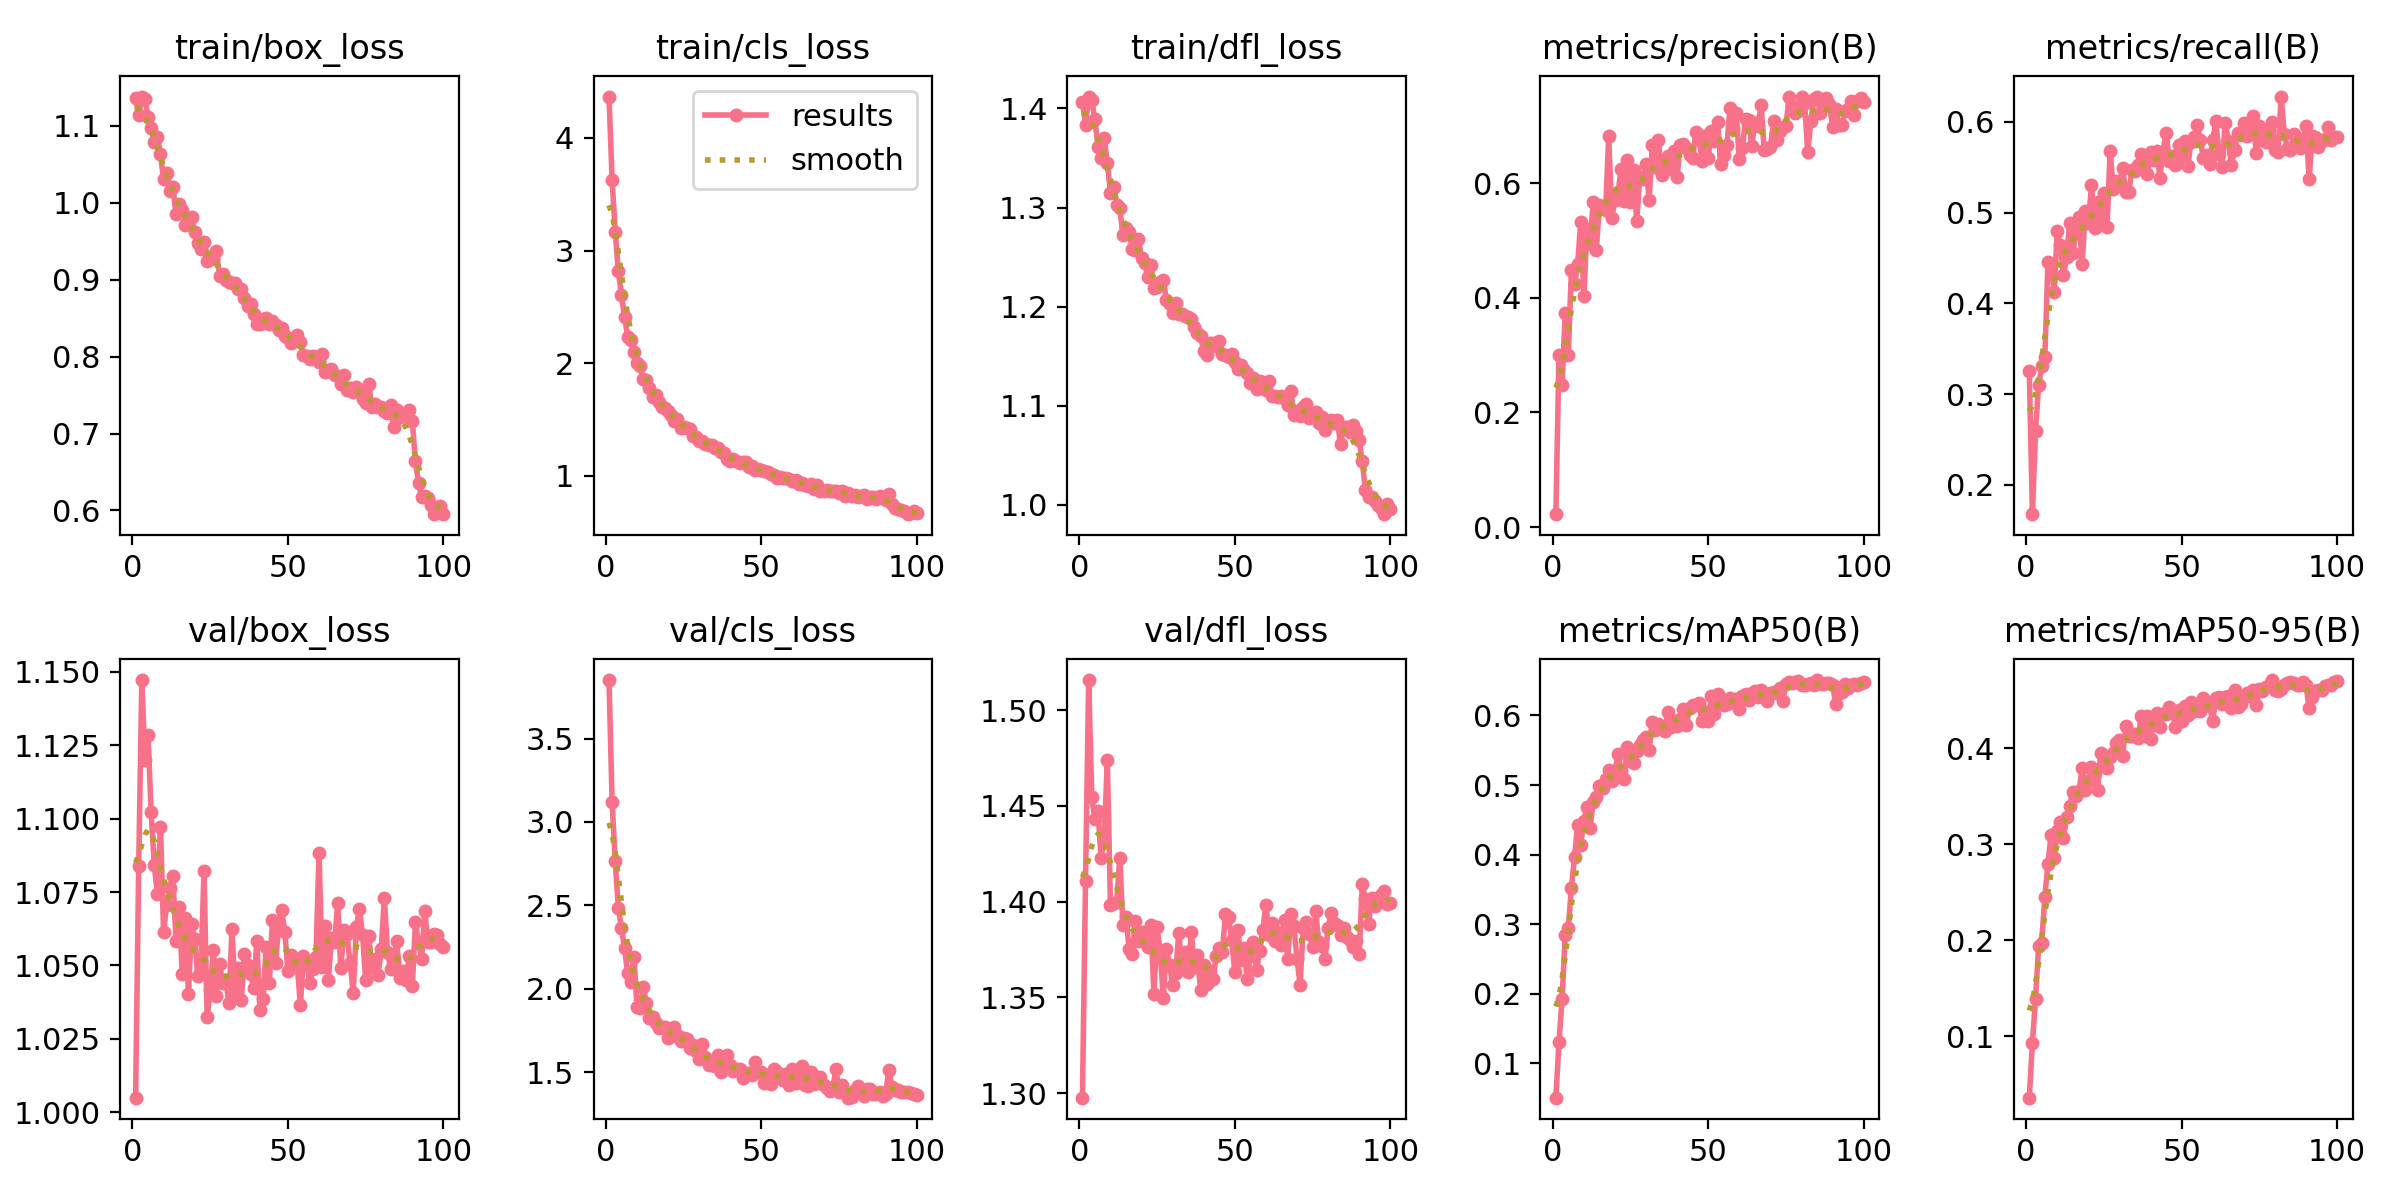


Confusion Matrix:


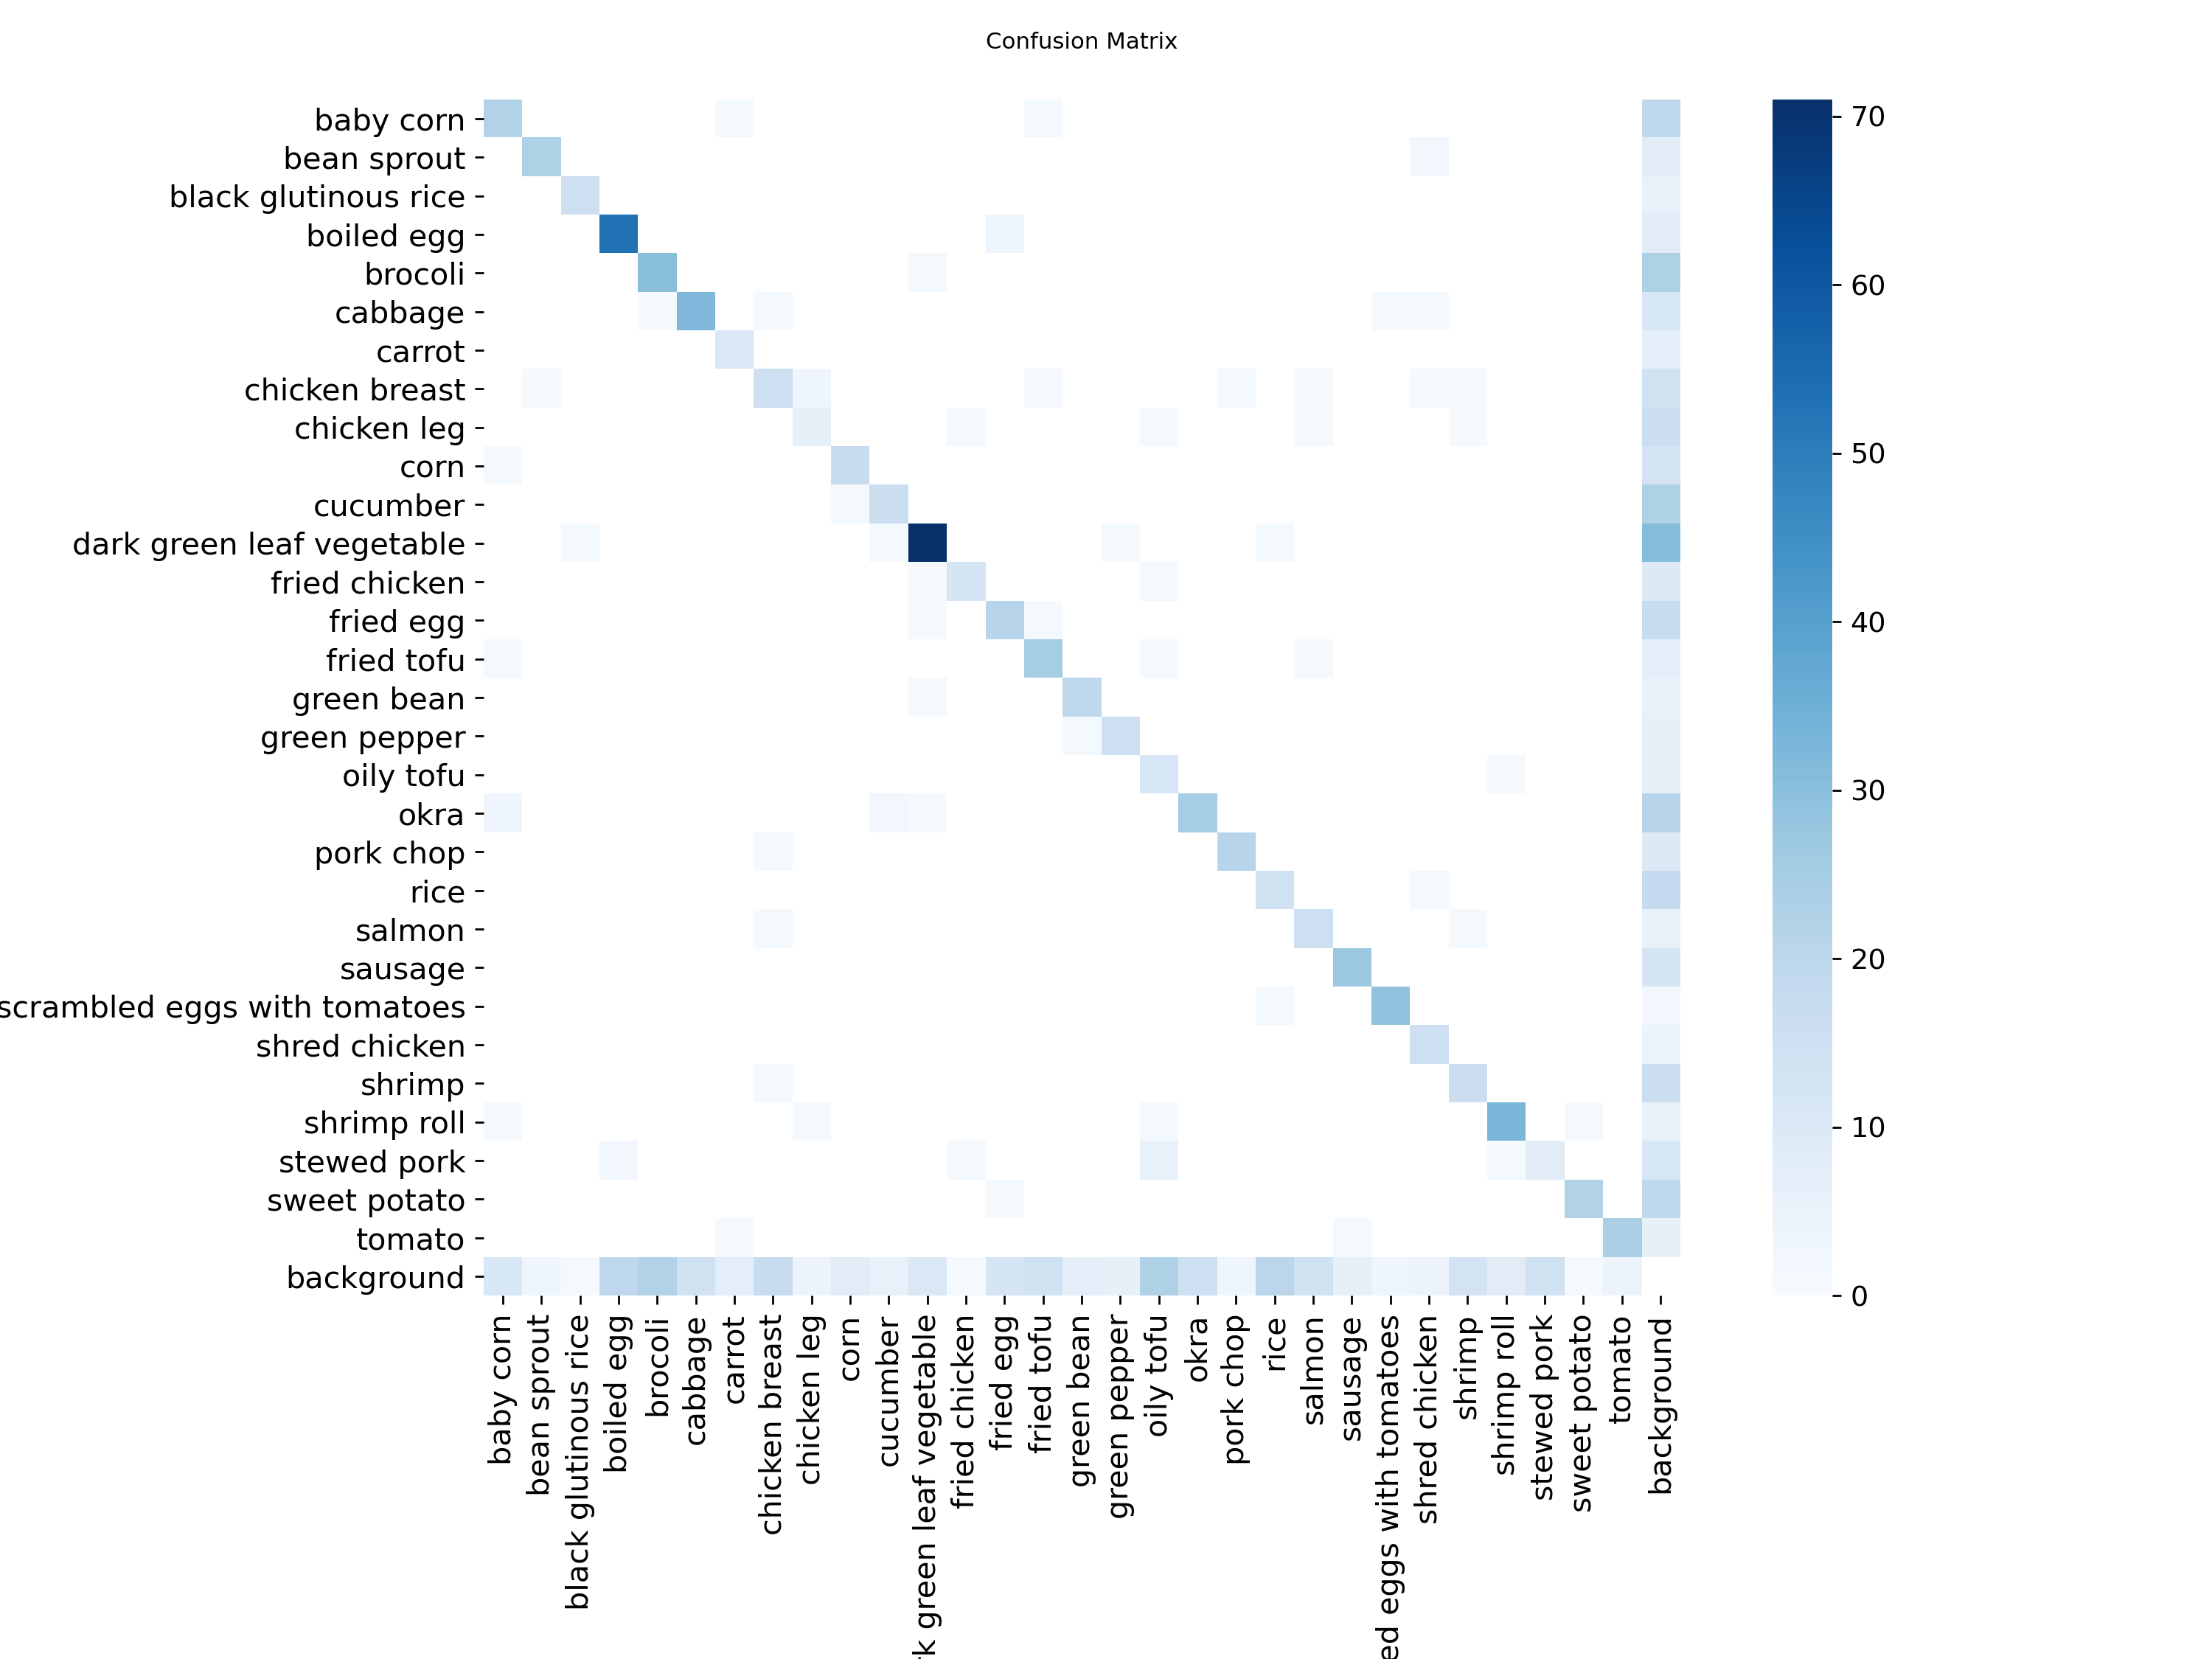

In [ ]:
# Display training plots and results
train_dir = f"{results_dir}/food_detection_v1"

# List of training plots to display
plot_files = [
    'results.png',
    'confusion_matrix.png',
    'F1_curve.png',
    'PR_curve.png',
    'P_curve.png',
    'R_curve.png'
]

print("Training Results Visualization:")
print("=" * 50)

for plot_file in plot_files:
    plot_path = os.path.join(train_dir, plot_file)
    if os.path.exists(plot_path):
        print(f"\n{plot_file.replace('_', ' ').replace('.png', '').title()}:")
        display(Image(plot_path))
    else:
        print(f"WARNING: {plot_file} not found")


Training Metrics Summary:
Final Epoch: 100
Box Loss (Train)    : 0.5952
Class Loss (Train)  : 0.6692
DFL Loss (Train)    : 0.9959
Precision           : 0.7408
Recall              : 0.5833
mAP@0.5             : 0.6479
mAP@0.5:0.95        : 0.4700


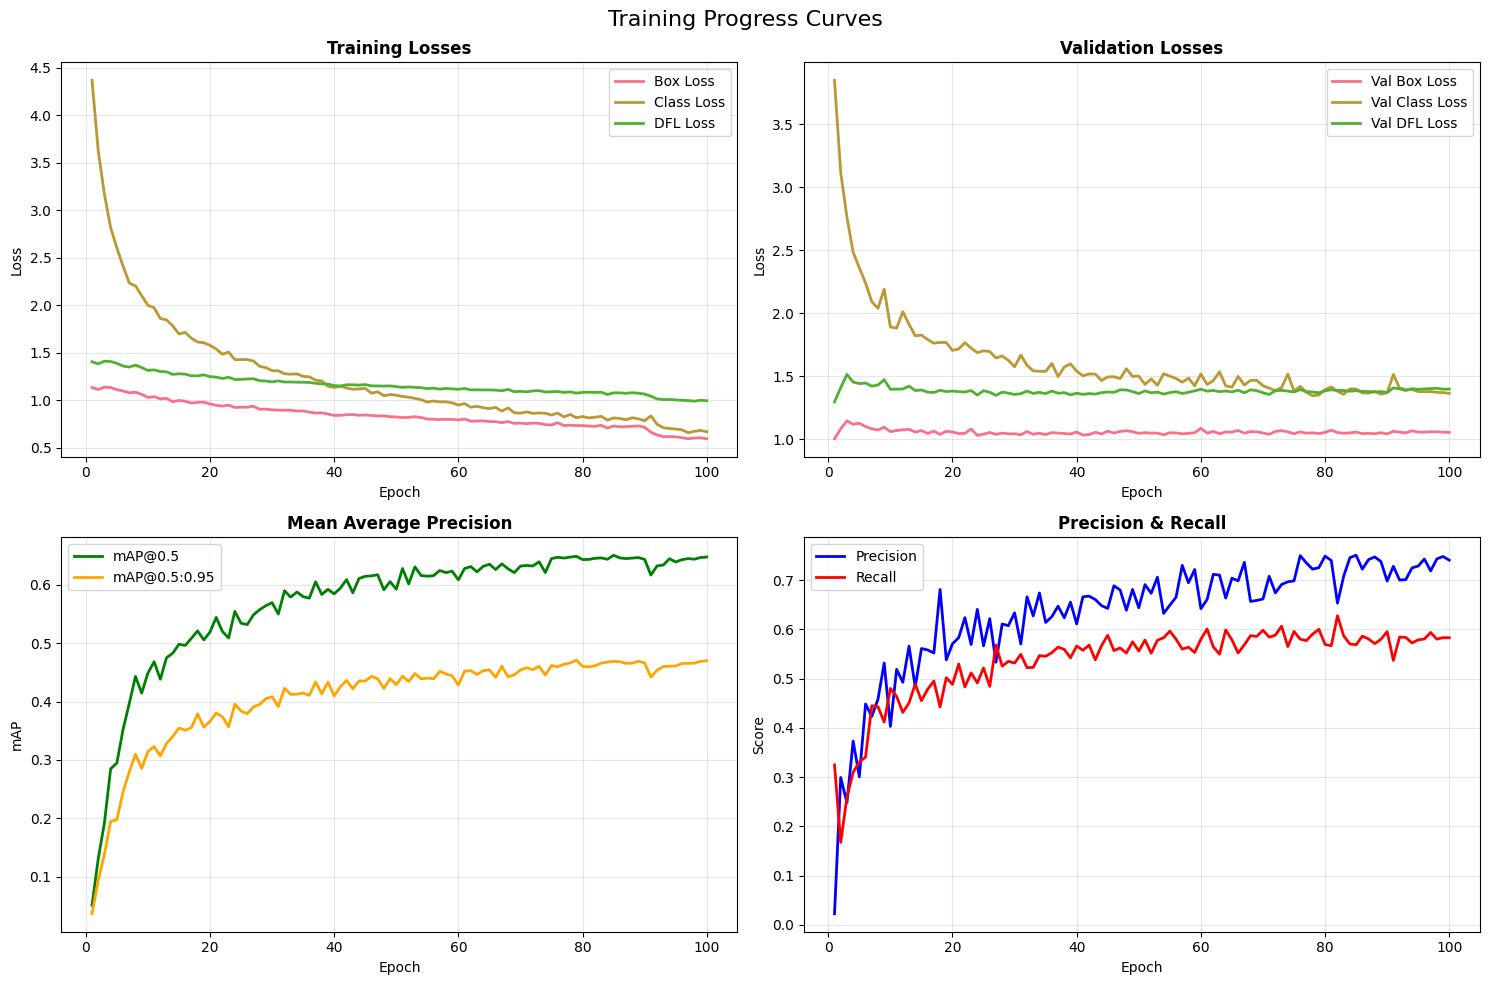

In [ ]:
# Load and analyze training metrics
import pandas as pd

results_csv = os.path.join(train_dir, 'results.csv')
if os.path.exists(results_csv):
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()  # Remove whitespace from column names

    print("Training Metrics Summary:")
    print("=" * 50)

    # Display final metrics
    final_epoch = df.iloc[-1]
    print(f"Final Epoch: {int(final_epoch['epoch'])}")

    # Key metrics to display
    metrics = {
        'Box Loss (Train)': 'train/box_loss',
        'Class Loss (Train)': 'train/cls_loss',
        'DFL Loss (Train)': 'train/dfl_loss',
        'Precision': 'metrics/precision(B)',
        'Recall': 'metrics/recall(B)',
        'mAP@0.5': 'metrics/mAP50(B)',
        'mAP@0.5:0.95': 'metrics/mAP50-95(B)'
    }

    for metric_name, column_name in metrics.items():
        if column_name in df.columns:
            value = final_epoch[column_name]
            print(f"{metric_name:20s}: {value:.4f}")

    # Plot training progress
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Progress Curves', fontsize=16)

    # Loss curves
    if 'train/box_loss' in df.columns:
        axes[0,0].plot(df['epoch'], df['train/box_loss'], label='Box Loss', linewidth=2)
        axes[0,0].plot(df['epoch'], df['train/cls_loss'], label='Class Loss', linewidth=2)
        axes[0,0].plot(df['epoch'], df['train/dfl_loss'], label='DFL Loss', linewidth=2)
        axes[0,0].set_title('Training Losses', fontweight='bold')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

    # Validation losses
    if 'val/box_loss' in df.columns:
        axes[0,1].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', linewidth=2)
        axes[0,1].plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss', linewidth=2)
        axes[0,1].plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss', linewidth=2)
        axes[0,1].set_title('Validation Losses', fontweight='bold')
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].set_ylabel('Loss')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

    # mAP curves
    if 'metrics/mAP50(B)' in df.columns:
        axes[1,0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5', linewidth=2, color='green')
        if 'metrics/mAP50-95(B)' in df.columns:
            axes[1,0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', linewidth=2, color='orange')
        axes[1,0].set_title('Mean Average Precision', fontweight='bold')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('mAP')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

    # Precision/Recall
    if 'metrics/precision(B)' in df.columns and 'metrics/recall(B)' in df.columns:
        axes[1,1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision', linewidth=2, color='blue')
        axes[1,1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall', linewidth=2, color='red')
        axes[1,1].set_title('Precision & Recall', fontweight='bold')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Score')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("WARNING: Training results CSV not found")


## Step 7: Model Validation and Testing


In [ ]:
# Load the best trained model for validation
best_model_path = os.path.join(train_dir, 'weights', 'best.pt')

if os.path.exists(best_model_path):
    print("Loading best trained model...")
    best_model = YOLO(best_model_path)
    print("SUCCESS: Best model loaded successfully!")

    # Run validation on the test set
    print("\nRunning model validation...")
    validation_results = best_model.val(
        data='/content/dataset.yaml',
        split='val',  # Use validation set
        imgsz=640,
        save_json=True,
        save_hybrid=True,
        conf=0.25,
        iou=0.5,
        plots=True
    )

    print("\nValidation Results:")
    print("=" * 50)
    print(f"mAP@0.5: {validation_results.box.map50:.4f}")
    print(f"mAP@0.5:0.95: {validation_results.box.map:.4f}")
    print(f"Precision: {validation_results.box.mp:.4f}")
    print(f"Recall: {validation_results.box.mr:.4f}")

    # Store validation results for later use
    final_metrics = {
        'map50': float(validation_results.box.map50),
        'map50_95': float(validation_results.box.map),
        'precision': float(validation_results.box.mp),
        'recall': float(validation_results.box.mr)
    }

else:
    print("ERROR: Best model not found. Please check training results.")
    final_metrics = {}


Testing model on sample images:

image 1/1 /content/Food_Dataset/test/images/veg6_jpg.rf.217b3a9451dc68c60c82b8938be2f0ba.jpg: 448x640 1 black glutinous rice, 1 boiled egg, 1 brocoli, 1 green pepper, 1 tomato, 68.3ms
Speed: 4.2ms preprocess, 68.3ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/training_results/test_predictions

Image: veg6_jpg.rf.217b3a9451dc68c60c82b8938be2f0ba.jpg
  - Class 4: 0.989
  - Class 3: 0.842
  - Class 29: 0.810
  - Class 16: 0.644
  - Class 2: 0.377

image 1/1 /content/Food_Dataset/test/images/2023-05-04_05-16-14_UTC_jpg.rf.62b31ef564a0763df9f739c146f71521.jpg: 480x640 2 dark green leaf vegetables, 2 salmons, 2 tomatos, 35.4ms
Speed: 3.3ms preprocess, 35.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/training_results/test_predictions2

Image: 2023-05-04_05-16-14_UTC_jpg.rf.62b31ef564a0763df9f739c146f71521.jpg
  - Class 21: 0.752
  - Class 11: 0.624
  - Class 29: 0.5

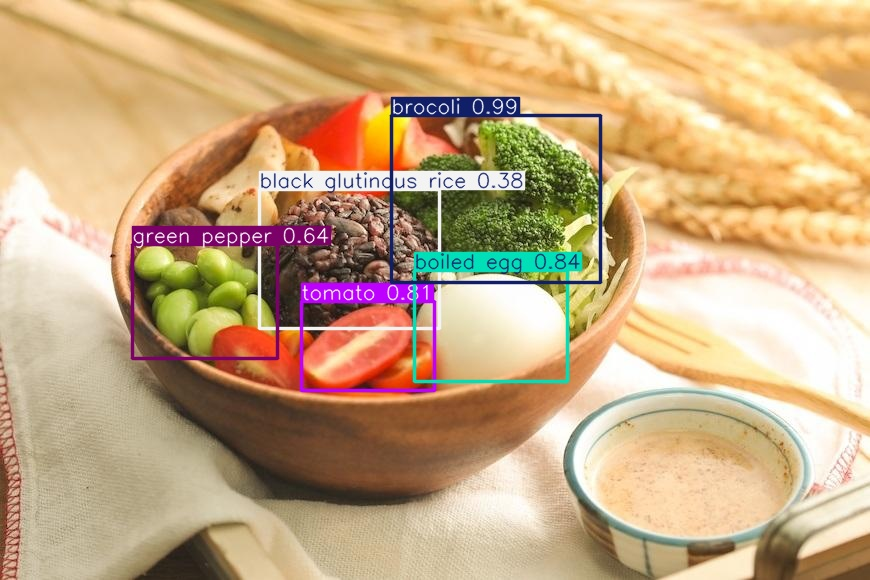

In [ ]:
# Test the model on sample images
test_images_path = '/content/Food_Dataset/test/images'

if os.path.exists(test_images_path) and 'best_model' in locals():
    # Get random test images
    import random
    test_images = [f for f in os.listdir(test_images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    sample_images = random.sample(test_images, min(5, len(test_images)))

    print("Testing model on sample images:")
    print("=" * 50)

    for img_name in sample_images:
        img_path = os.path.join(test_images_path, img_name)

        # Run inference
        results = best_model(img_path, conf=0.25, save=True, project=results_dir, name='test_predictions')

        print(f"\nImage: {img_name}")

        # Display predictions
        for result in results:
            boxes = result.boxes
            if boxes is not None and len(boxes) > 0:
                for box in boxes:
                    class_id = int(box.cls[0])
                    confidence = float(box.conf[0])
                    class_name = data_config['names'][class_id] if 'data_config' in locals() else f"Class {class_id}"
                    print(f"  - {class_name}: {confidence:.3f}")
            else:
                print("  - No detections")

    # Display some prediction images
    prediction_dir = f"{results_dir}/test_predictions"
    if os.path.exists(prediction_dir):
        pred_images = [f for f in os.listdir(prediction_dir) if f.endswith('.jpg')]
        if pred_images:
            print(f"\nSample Prediction Results:")
            for i, pred_img in enumerate(pred_images[:3]):  # Show first 3 predictions
                pred_path = os.path.join(prediction_dir, pred_img)
                print(f"\nPrediction {i+1}:")
                display(Image(pred_path))

else:
    print("WARNING: Test images not found or model not loaded")


## Step 8: Model Export and Download


In [ ]:
# Export model in multiple formats and create comprehensive package
if 'best_model' in locals() and os.path.exists(best_model_path):
    print("Exporting model in different formats...")
    print("=" * 50)

    # Export formats for different deployment scenarios
    export_formats = {
        'ONNX': 'onnx',           # Most compatible, good for deployment
        'TorchScript': 'torchscript',  # PyTorch deployment
        'TensorFlow Lite': 'tflite',   # Mobile deployment
    }

    exported_models = {}
    for format_name, format_type in export_formats.items():
        try:
            print(f"\nExporting to {format_name}...")
            exported_path = best_model.export(format=format_type, imgsz=640)
            exported_models[format_name] = exported_path
            print(f"SUCCESS: {format_name} export successful: {exported_path}")
        except Exception as e:
            print(f"WARNING: {format_name} export failed: {str(e)}")

    # Create comprehensive model information
    model_info = {
        'model_name': 'HealthSphere_Food_Detection_v1',
        'framework': 'YOLOv8',
        'model_size': TRAINING_CONFIG['model_size'],
        'num_classes': data_config['nc'] if 'data_config' in locals() else 30,
        'class_names': data_config['names'] if 'data_config' in locals() else [],
        'image_size': TRAINING_CONFIG['image_size'],
        'training_epochs': TRAINING_CONFIG['epochs'],
        'dataset_info': {
            'total_images': 1596,
            'train_images': 1204,
            'valid_images': 313,
            'test_images': 79
        },
        'performance_metrics': final_metrics if 'final_metrics' in locals() else {},
        'training_config': TRAINING_CONFIG,
        'exported_formats': list(exported_models.keys()),
        'usage_instructions': {
            'python_example': '''
from ultralytics import YOLO

# Load model
model = YOLO('best.pt')

# Run inference
results = model('food_image.jpg', conf=0.25)

# Process results
for result in results:
    boxes = result.boxes
    for box in boxes:
        class_id = int(box.cls[0])
        confidence = float(box.conf[0])
        class_name = model.names[class_id]
        print(f"Detected: {class_name} ({confidence:.3f})")
'''
        }
    }

    # Save model information
    model_info_path = '/content/model_info.yaml'
    with open(model_info_path, 'w') as f:
        yaml.dump(model_info, f, default_flow_style=False)

    print(f"\nModel information saved: {model_info_path}")

else:
    print("ERROR: Model not available for export. Please ensure training completed successfully.")


In [ ]:
# Create comprehensive download package
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
zip_filename = f'/content/HealthSphere_Food_Detection_v1_{timestamp}.zip'

print("Creating comprehensive model package...")
print("=" * 50)

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Core model files
    if os.path.exists(best_model_path):
        zipf.write(best_model_path, 'weights/best.pt')
        print("Added: best.pt")

    last_model_path = f'{train_dir}/weights/last.pt'
    if os.path.exists(last_model_path):
        zipf.write(last_model_path, 'weights/last.pt')
        print("Added: last.pt")

    # Configuration files
    if os.path.exists('/content/dataset.yaml'):
        zipf.write('/content/dataset.yaml', 'dataset.yaml')
        print("Added: dataset.yaml")

    if os.path.exists('/content/model_info.yaml'):
        zipf.write('/content/model_info.yaml', 'model_info.yaml')
        print("Added: model_info.yaml")

    # Training results
    results_csv = f'{train_dir}/results.csv'
    if os.path.exists(results_csv):
        zipf.write(results_csv, 'training_results.csv')
        print("Added: training_results.csv")

    # Training plots
    plot_files = ['results.png', 'confusion_matrix.png', 'F1_curve.png', 'PR_curve.png']
    for plot_file in plot_files:
        plot_path = os.path.join(train_dir, plot_file)
        if os.path.exists(plot_path):
            zipf.write(plot_path, f'plots/{plot_file}')
            print(f"Added: plots/{plot_file}")

    # Exported models
    for format_name, model_path in exported_models.items():
        if os.path.exists(model_path):
            filename = os.path.basename(model_path)
            zipf.write(model_path, f'exported_models/{filename}')
            print(f"Added: exported_models/{filename}")

print(f"\nSUCCESS: Model package created successfully!")
print(f"Package: {zip_filename}")
print(f"Package size: {os.path.getsize(zip_filename) / (1024*1024):.2f} MB")

# Display package contents
print(f"\nPackage Contents:")
print("  weights/")
print("     - best.pt (main model file)")
print("     - last.pt (backup model file)")
print("  exported_models/")
print("     - ONNX, TorchScript, TensorFlow Lite formats")
print("  plots/")
print("     - Training visualizations")
print("  dataset.yaml (dataset configuration)")
print("  model_info.yaml (comprehensive model information)")
print("  training_results.csv (training metrics)")


Creating comprehensive model package...
Added: best.pt
Added: last.pt
Added: dataset.yaml
Added: model_info.yaml
Added: training_results.csv
Added: plots/results.png
Added: plots/confusion_matrix.png
Added: exported_models/best.onnx
Added: exported_models/best.torchscript
Added: exported_models/best_float32.tflite

SUCCESS: Model package created successfully!
Package: /content/HealthSphere_Food_Detection_v1_20250810_152222.zip
Package size: 41.77 MB

Package Contents:
  weights/
     - best.pt (main model file)
     - last.pt (backup model file)
  exported_models/
     - ONNX, TorchScript, TensorFlow Lite formats
  plots/
     - Training visualizations
  dataset.yaml (dataset configuration)
  model_info.yaml (comprehensive model information)
  training_results.csv (training metrics)


In [ ]:
# Download the model package
print("Downloading model package...")
print("=" * 50)
print("The download will start automatically.")

files.download(zip_filename)

print("\nSUCCESS: Download completed!")
print("\nNext Steps:")
print("1. Extract the downloaded ZIP file")
print("2. Place 'weights/best.pt' in your backend-api/app/ml/models/ directory")
print("3. Use the integration guide below to implement in your backend")
print("4. Test the model with your HealthSphere AI application")


The download will start automatically.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


SUCCESS: Download completed!

Next Steps:
1. Extract the downloaded ZIP file
2. Place 'weights/best.pt' in your backend-api/app/ml/models/ directory
3. Use the integration guide below to implement in your backend
4. Test the model with your HealthSphere AI application


##  Step 9: Backend Integration Guide

###  File Placement
1. **Extract** the downloaded ZIP file
2. **Copy** `weights/best.pt` to `backend-api/app/ml/models/best.pt`
3. **Copy** `dataset.yaml` to `backend-api/app/data/dataset.yaml`

### Backend Integration Code

#### 1. Food Detection Service (`app/ml/inference/food_detector.py`)

```python
from ultralytics import YOLO
import cv2
import numpy as np
from typing import List, Dict
import yaml
import os

class FoodDetector:
    def __init__(self, model_path: str = "app/ml/models/best.pt"):
        """Initialize the YOLOv8 food detection model"""
        self.model = YOLO(model_path)
        self.confidence_threshold = 0.25
        self.iou_threshold = 0.5
        
        # Load class names from dataset config
        dataset_config_path = "app/data/dataset.yaml"
        if os.path.exists(dataset_config_path):
            with open(dataset_config_path, 'r') as f:
                config = yaml.safe_load(f)
                self.class_names = config['names']
        else:
            self.class_names = self.model.names
    
    def detect_food_items(self, image_path: str) -> List[Dict]:
        """
        Detect food items in an image
        
        Args:
            image_path: Path to the image file
            
        Returns:
            List of detected food items with confidence scores and bounding boxes
        """
        results = self.model(
            image_path,
            conf=self.confidence_threshold,
            iou=self.iou_threshold,
            verbose=False
        )
        
        detections = []
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    class_id = int(box.cls[0])
                    confidence = float(box.conf[0])
                    bbox = box.xyxy[0].tolist()  # [x1, y1, x2, y2]
                    
                    detection = {
                        'class_id': class_id,
                        'class_name': self.class_names[class_id],
                        'confidence': confidence,
                        'bbox': {
                            'x1': bbox[0],
                            'y1': bbox[1],
                            'x2': bbox[2],
                            'y2': bbox[3]
                        }
                    }
                    detections.append(detection)
        
        return detections
    
    def detect_from_bytes(self, image_bytes: bytes) -> List[Dict]:
        """Detect food items from image bytes"""
        import io
        from PIL import Image
        
        # Convert bytes to PIL Image
        image = Image.open(io.BytesIO(image_bytes))
        
        # Run detection
        results = self.model(image, conf=self.confidence_threshold, verbose=False)
        
        # Process results (same as above)
        detections = []
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    class_id = int(box.cls[0])
                    confidence = float(box.conf[0])
                    bbox = box.xyxy[0].tolist()
                    
                    detection = {
                        'class_id': class_id,
                        'class_name': self.class_names[class_id],
                        'confidence': confidence,
                        'bbox': {
                            'x1': bbox[0],
                            'y1': bbox[1],
                            'x2': bbox[2],
                            'y2': bbox[3]
                        }
                    }
                    detections.append(detection)
        
        return detections
```

#### 2. API Endpoint (`app/api/v1/endpoints/ml.py`)

```python
from fastapi import APIRouter, UploadFile, File, HTTPException
from fastapi.responses import JSONResponse
from app.ml.inference.food_detector import FoodDetector
from app.services.nutrition_service import NutritionService
import os
import uuid
from typing import List, Dict

router = APIRouter()
food_detector = FoodDetector()
nutrition_service = NutritionService()

@router.post("/detect-food")
async def detect_food_in_image(file: UploadFile = File(...)):
    """
    Detect food items in uploaded image and return nutritional information
    """
    try:
        # Validate file type
        if not file.content_type.startswith('image/'):
            raise HTTPException(status_code=400, detail="File must be an image")
        
        # Read image bytes
        image_bytes = await file.read()
        
        # Detect food items
        detections = food_detector.detect_from_bytes(image_bytes)
        
        if not detections:
            return JSONResponse(content={
                "message": "No food items detected",
                "detections": [],
                "nutritional_info": []
            })
        
        # Get nutritional information for detected food items
        nutritional_data = []
        for detection in detections:
            food_name = detection['class_name']
            confidence = detection['confidence']
            
            # Get nutrition data from external API (Nutritionix)
            nutrition_info = await nutrition_service.get_nutrition_data(food_name)
            
            nutritional_data.append({
                "food_item": food_name,
                "confidence": confidence,
                "bbox": detection['bbox'],
                "nutrition": nutrition_info
            })
        
        return JSONResponse(content={
            "message": f"Detected {len(detections)} food items",
            "detections": detections,
            "nutritional_info": nutritional_data
        })
        
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Error processing image: {str(e)}")

@router.post("/analyze-meal")
async def analyze_complete_meal(file: UploadFile = File(...)):
    """
    Analyze a complete meal and provide comprehensive nutritional breakdown
    """
    try:
        # Detect food items
        image_bytes = await file.read()
        detections = food_detector.detect_from_bytes(image_bytes)
        
        if not detections:
            return JSONResponse(content={
                "message": "No food items detected in meal",
                "total_nutrition": {},
                "food_items": []
            })
        
        # Calculate total nutritional information
        total_nutrition = {
            "calories": 0,
            "protein": 0,
            "carbohydrates": 0,
            "fat": 0,
            "fiber": 0,
            "sugar": 0
        }
        
        food_items = []
        for detection in detections:
            food_name = detection['class_name']
            nutrition_info = await nutrition_service.get_nutrition_data(food_name)
            
            # Add to totals
            if nutrition_info:
                total_nutrition["calories"] += nutrition_info.get("calories", 0)
                total_nutrition["protein"] += nutrition_info.get("protein", 0)
                total_nutrition["carbohydrates"] += nutrition_info.get("carbohydrates", 0)
                total_nutrition["fat"] += nutrition_info.get("fat", 0)
                total_nutrition["fiber"] += nutrition_info.get("fiber", 0)
                total_nutrition["sugar"] += nutrition_info.get("sugar", 0)
            
            food_items.append({
                "name": food_name,
                "confidence": detection['confidence'],
                "nutrition": nutrition_info
            })
        
        return JSONResponse(content={
            "message": f"Analyzed meal with {len(detections)} food items",
            "total_nutrition": total_nutrition,
            "food_items": food_items,
            "recommendations": nutrition_service.get_meal_recommendations(total_nutrition)
        })
        
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Error analyzing meal: {str(e)}")
```

###  Integration Steps

1. **Install Dependencies** in your backend:
   ```bash
   pip install ultralytics opencv-python pillow
   ```

2. **Update main.py** to include the ML router:
   ```python
   from app.api.v1.endpoints import ml
   
   app.include_router(ml.router, prefix="/api/v1/ml", tags=["machine-learning"])
   ```

3. **Environment Variables** (`.env`):
   ```env
   MODEL_PATH=app/ml/models/best.pt
   CONFIDENCE_THRESHOLD=0.25
   IOU_THRESHOLD=0.5
   ```

4. **Test the Integration**:
   ```bash
   curl -X POST "http://localhost:8000/api/v1/ml/detect-food" \
        -H "accept: application/json" \
        -H "Content-Type: multipart/form-data" \
        -F "file=@test_food_image.jpg"
   ```

###  Expected Performance
- **Inference Speed**: ~50-100ms per image (depending on hardware)
- **Model Size**: ~6-14MB (YOLOv8n variant)
- **Accuracy**: Based on your training results
- **Supported Formats**: JPG, PNG, JPEG

###  Production Deployment
- Use **ONNX** format for faster inference
- Implement **batch processing** for multiple images  
- Add **image preprocessing** pipeline
- Set up **model versioning** system
- Configure **logging** and **monitoring**


In [ ]:
# Start training
print(" Starting model training...")
print("This may take several hours depending on your configuration.")
print("=" * 70)

# Train the model
results = model.train(
    data='/content/dataset.yaml',
    epochs=TRAINING_CONFIG['epochs'],
    batch=TRAINING_CONFIG['batch_size'],
    imgsz=TRAINING_CONFIG['image_size'],
    patience=TRAINING_CONFIG['patience'],
    save_period=TRAINING_CONFIG['save_period'],
    workers=TRAINING_CONFIG['workers'],
    device=TRAINING_CONFIG['device'],
    project=results_dir,
    name='food_detection_v1',
    exist_ok=True,
    verbose=True,
    plots=True,
    save=True,
    save_txt=True
)

print("\n Training completed!")
print(f" Results saved to: {results_dir}/food_detection_v1")


## 📦 Step 6: Model Export and Download


In [ ]:
# Load the best trained model
train_dir = f"{results_dir}/food_detection_v1"
best_model_path = os.path.join(train_dir, 'weights', 'best.pt')

if os.path.exists(best_model_path):
    print("Loading best trained model...")
    best_model = YOLO(best_model_path)
    print("Best model loaded successfully!")

    # Export model in different formats
    print("\n Exporting model...")
    try:
        # Export to ONNX (most compatible)
        onnx_model = best_model.export(format='onnx', imgsz=640)
        print(f" ONNX export successful: {onnx_model}")
    except Exception as e:
        print(f"ONNX export failed: {str(e)}")

    # Create download package
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    zip_filename = f'/content/HealthSphere_Food_Detection_v1_{timestamp}.zip'

    print(f"\n Creating model package: {zip_filename}")
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Add model weights
        zipf.write(best_model_path, 'weights/best.pt')
        zipf.write(f'{train_dir}/weights/last.pt', 'weights/last.pt')

        # Add configuration
        zipf.write('/content/dataset.yaml', 'dataset.yaml')

        # Add training results if they exist
        results_csv = f'{train_dir}/results.csv'
        if os.path.exists(results_csv):
            zipf.write(results_csv, 'training_results.csv')

    print(" Model package created successfully!")
    print(" Starting download...")
    files.download(zip_filename)

else:
    print(" Best model not found. Please check training results.")
